## Importing Modules.

In [1]:
!pip install einops

import tempfile
import time
import logging
from functools import wraps
import math
import json
import os
import sys
from collections import OrderedDict
from io import BytesIO
from typing import Optional, Iterator, cast, TypeVar, Generic, Callable, Union
from pathlib import Path
import requests
import torch as t
import torchvision
import pandas as pd
import numpy as np
from einops import rearrange
from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image, UnidentifiedImageError
from torch import nn
from torch.nn.functional import conv1d as torch_conv1d
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm.auto import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00


## Helper utilities

In [2]:
DEBUG_TOLERANCES = os.getenv("DEBUG_TOLERANCES")

def assert_all_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    """Assert that actual and expected are exactly equal (to floating point precision)."""
    mask = actual == expected
    if not mask.all().item():
        bad = mask.nonzero()
        msg = f"Did not match at {len(bad)} indexes: {bad[:10]}{'...' if len(bad) > 10 else ''}"
        raise AssertionError(f"{msg}\nActual:\n{actual}\nExpected:\n{expected}")

def assert_shape_equal(actual : t.Tensor, expected : t.Tensor) -> None:
    if actual.shape != expected.shape:
        raise AssertionError(f"expected shape={expected.shape}, got {actual.shape}")
        
def allclose(actual : t.Tensor, expected : t.Tensor, rtol = 1e-4) -> None:
    
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    right = rtol * expected.abs()
    num_wrong = (left > right).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")
    
def test_is_equal(actual: t.Tensor, expected: t.Tensor, test_name: str) -> None:
    try:
        run_and_report(assert_all_equal, test_name, actual, expected)
    except AssertionError as e:
        print(f"Test failed: {test_name}")
        raise e
        
TEST_FN_PASSED = {}

def report_success(testname):
    """POST to the server indicating success at the given test.

    Used to help the TAs know how long each section takes to complete.
    """
    server = os.environ.get("MLAB_SERVER")
    email = os.environ.get("MLAB_EMAIL")
    if server:
        if email:
            r = requests.post(
                server + "/api/report_success",
                json=dict(email=email, testname=testname),
            )
            if r.status_code != http.HTTPStatus.NO_CONTENT:
                raise ValueError(f"Got status code from server: {r.status_code}")
        else:
            raise ValueError(f"Server set to {server} but no MLAB_EMAIL set!")
    else:
        if email:
            raise ValueError(f"Email set to {email} but no MLAB_SERVER set!")
        else:
            return  # local dev, do nothing
        
def run_and_report(test_func: Callable, name: str, *test_func_args, **test_func_kwargs):
    start = time.time()
    out = test_func(*test_func_args, **test_func_kwargs)
    elapsed = time.time() - start
    print(f"{name} passed in {elapsed:.2f}s.")
    if not TEST_FN_PASSED.get(name):
        report_success(name)
        TEST_FN_PASSED[name] = True
    return out

def allclose_atol(actual: t.Tensor, expected: t.Tensor, atol: float) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    num_wrong = (left > atol).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")

def report(test_func):
    name = f"{test_func.__module__}.{test_func.__name__}"
    # This can happen when using autoreload, so don't complain about it.
    # if name in TEST_FN_PASSED:
    #     raise KeyError(f"Already registered: {name}")
    TEST_FN_PASSED[name] = False

    @wraps(test_func)
    def wrapper(*args, **kwargs):
        return run_and_report(test_func, name, *args, **kwargs)

    return wrapper

def allclose_atol(actual: t.Tensor, expected: t.Tensor, atol: float) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    num_wrong = (left > atol).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")
        
@report
def test_trace(trace_fn):
    """Trace should be equal to the sum along the main diagonal."""
    for n in range(10):
        assert trace_fn(t.zeros((n, n), dtype=t.long)) == 0
        assert trace_fn(t.eye(n, dtype=t.long)) == n

        x = t.randint(0, 10, (n, n))
        expected = t.trace(x)
        actual = trace_fn(x)
        assert actual == expected
@report
def test_trace_expand(trace_fn):
    """Trace should work on a view created by torch.expand."""
    x = t.tensor([1]).expand((5, 5))
    assert trace_fn(x) == 5


@report
def test_trace_transpose(trace_fn):
    """Trace should work on a view created by transpose."""
    x = t.arange(16).reshape((4, 4)).T
    assert trace_fn(x) == 30
    
@report
def test_matmul(matmul_fn):
    """A simple 2x2 matmul should work and can be verified by hand."""
    x = t.arange(4).reshape(2, 2)
    expected = t.tensor([[2, 3], [6, 11]])
    assert_all_equal(matmul_fn(x, x), expected)
    
@report
def test_matmul_transpose(matmul_fn):
    """Matmul of a transposed tensor should work."""
    x = t.arange(6).view((2, 3))
    expected = t.tensor([[5, 14], [14, 50]])
    assert_all_equal(matmul_fn(x, x.T), expected)
    
@report
def test_matmul_expand(matmul_fn):
    """Matmul should work on a view created by torch.expand."""
    x = t.arange(3).expand((2, 3))
    expected = t.tensor([[5, 5], [5, 5]])
    assert_all_equal(matmul_fn(x, x.T), expected)
    
@report
def test_matmul_skip(matmul_fn):
    """Matmul should work on a view of a larger tensor with all strides > 1."""
    big = t.arange(-8, 8)
    x = big.as_strided(size=(2, 2), stride=(2, 4), storage_offset=8)
    y = big.as_strided(size=(2, 2), stride=(3, 2), storage_offset=8)
    expected = t.tensor([[12, 20], [18, 34]])
    assert_all_equal(matmul_fn(x, y), expected)
    
@report
def test_conv1d_minimal(conv1d_minimal, n_tests = 20):
    # TBD lowpri: check transpose and expand here as well - should be fine
    
    for _ in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 30)
        ci = np.random.randint(1, 5)
        co = np.random.randint(1, 5)
        kernel_size = np.random.randint(1, 10)
        
        x = t.randn((b, ci, h))
        weights = t.randn((co, ci, kernel_size))
        
        my_output = conv1d_minimal(x, weights)

        torch_output = t.conv1d(
            x,
            weights,
            stride = 1,
            padding = 0,
        )
        allclose_atol(my_output, torch_output, 1e-4)
        
@report
def test_conv2d_minimal(conv2d_minimal, dtype, atol, n_tests=2):
    """Compare against torch.conv2d.

    Due to floating point rounding, they can be quite different in float32 but should be nearly identical in float64.
    """

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = t.randn((b, ci, h, w), dtype=dtype)
        weights = t.randn((co, ci, *kernel_size), dtype=dtype)
        my_output = conv2d_minimal(x, weights)
        torch_output = t.conv2d(x, weights)
        allclose_atol(my_output, torch_output, atol)
        
@report
def test_pad1d(pad1d):
    """Should work with one channel of width 4."""
    x = t.arange(4).float().view((1, 1, 4))
    actual = pad1d(x, 1, 3, -2.0)
    expected = t.tensor([[[-2.0, 0.0, 1.0, 2.0, 3.0, -2.0, -2.0, -2.0]]])
    assert_all_equal(actual, expected)
    
@report
def test_pad1d_multi_channel(pad1d):
    """Should work with two channels of width 2."""
    x = t.arange(4).float().view((1, 2, 2))
    actual = pad1d(x, 0, 2, -3.0)
    expected = t.tensor([[[0.0, 1.0, -3.0, -3.0], [2.0, 3.0, -3.0, -3.0]]])
    assert_all_equal(actual, expected)
    
@report
def test_pad2d(pad):
    """Should work with one channel of 2x2."""
    x = t.arange(4).float().view((1, 1, 2, 2))
    expected = t.tensor(
        [
            [
                [
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 1.0, 0.0],
                    [2.0, 3.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0],
                ]
            ]
        ]
    )
    actual = pad(x, 0, 1, 2, 3, 0.0)
    assert_all_equal(actual, expected)


@report
def test_pad2d_multi_channel(pad):
    """Should work with two channels of 2x1."""
    x = t.arange(4).float().view((1, 2, 2, 1))
    expected = t.tensor([[[[-1.0, 0.0], [-1.0, 1.0], [-1.0, -1.0]], [[-1.0, 2.0], [-1.0, 3.0], [-1.0, -1.0]]]])
    actual = pad(x, 1, 0, 0, 1, -1.0)
    assert_all_equal(actual, expected)
    
@report
def test_conv1d(my_conv, n_tests=10):

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)
        stride = np.random.randint(1, 5)
        padding = np.random.randint(0, 5)
        kernel_size = np.random.randint(1, 10)

        x = t.randn((b, ci, h))
        weights = t.randn((co, ci, kernel_size))

        my_output = my_conv(x, weights, stride=stride, padding=padding)

        torch_output = t.conv1d(x, weights, stride=stride, padding=padding)
        allclose_atol(my_output, torch_output, 1e-4)
        
        
@report
def test_conv2d(my_conv, dtype, atol, n_tests=2):

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 300)
        w = np.random.randint(10, 300)
        ci = np.random.randint(1, 20)
        co = np.random.randint(1, 20)

        stride = tuple(np.random.randint(1, 5, size=(2,)))
        padding = tuple(np.random.randint(0, 5, size=(2,)))
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))

        x = t.randn((b, ci, h, w), dtype=dtype)
        weights = t.randn((co, ci, *kernel_size), dtype=dtype)
        my_output = my_conv(x, weights, stride=stride, padding=padding)
        torch_output = t.conv2d(x, weights, stride=stride, padding=padding)
        allclose_atol(my_output, torch_output, atol)
        
@report
def test_maxpool2d(my_maxpool2d, n_tests=20):

    for i in range(n_tests):
        b = np.random.randint(1, 10)
        h = np.random.randint(10, 50)
        w = np.random.randint(10, 50)
        ci = np.random.randint(1, 20)

        none_stride = bool(np.random.randint(2))
        if none_stride:
            stride = None
        else:
            stride = tuple(np.random.randint(1, 5, size=(2,)))
        kernel_size = tuple(np.random.randint(1, 10, size=(2,)))
        kH, kW = kernel_size
        padding = np.random.randint(0, 1 + kH // 2), np.random.randint(0, 1 + kW // 2)

        x = t.randn((b, ci, h, w))

        my_output = my_maxpool2d(
            x,
            kernel_size,
            stride=stride,
            padding=padding,
        )

        torch_output = t.max_pool2d(
            x,
            kernel_size,
            stride=stride,  # type: ignore (None actually is allowed)
            padding=padding,
        )
        allclose_atol(my_output, torch_output, 1e-4)
        
        
@report
def test_maxpool2d_module(MaxPool2d):
    """Should take the max over a 4x4 grid of the numbers [0..16) correctly."""
    m = MaxPool2d((2, 2), stride=2, padding=0)
    x = t.arange(16).reshape((1, 1, 4, 4)).float()
    expected = t.tensor([[5.0, 7.0], [13.0, 15.0]])
    assert_all_equal(m(x), expected)
    


@report
def test_linear_forward(Linear):
    """Your Linear should produce identical results to torch.nn given identical parameters."""
    x = t.rand((10, 512))
    yours = Linear(512, 64)

    assert yours.weight.shape == (64, 512)
    assert yours.bias.shape == (64,)

    official = t.nn.Linear(512, 64)
    yours.weight = official.weight
    yours.bias = official.bias
    actual = yours(x)
    expected = official(x)
    allclose(actual, expected)
    

@report
def test_linear_parameters(Linear):
    m = Linear(2, 3)
    params = dict(m.named_parameters())
    assert len(params) == 2, f"Your model has {len(params)} recognized Parameters"
    assert list(params.keys()) == [
        "weight",
        "bias",
    ], "For compatibility with PyTorch, your fields should be named weight and bias."


@report
def test_linear_no_bias(Linear):
    m = Linear(3, 4, bias=False)
    assert m.bias is None, "Bias should be None when not enabled."
    assert len(list(m.parameters())) == 1
    
@report
def test_conv2d_module(Conv2d):
    """Your weight should be called 'weight' and have an appropriate number of elements.

    TBD: anything else here? We already tested the functional form sufficiently beforehand.
    """
    m = Conv2d(4, 5, (3, 3))
    assert isinstance(m.weight, t.nn.parameter.Parameter), "Weight should be registered a parameter!"
    assert m.weight.nelement() == 4 * 5 * 3 * 3
    

@report
def test_batchnorm2d_module(BatchNorm2d):
    """The public API of the module should be the same as the real PyTorch version."""
    num_features = 2
    bn = BatchNorm2d(num_features)
    assert bn.num_features == num_features
    assert isinstance(bn.weight, t.nn.parameter.Parameter)
    assert isinstance(bn.bias, t.nn.parameter.Parameter)
    assert isinstance(bn.running_mean, t.Tensor)
    assert isinstance(bn.running_var, t.Tensor)
    assert isinstance(bn.num_batches_tracked, t.Tensor)


@report
def test_batchnorm2d_forward(BatchNorm2d):
    """For each channel, mean should be very close to 0 and std kinda close to 1 (because of eps)."""
    num_features = 2
    bn = BatchNorm2d(num_features)
    assert bn.training
    x = t.randn((100, num_features, 3, 4))
    out = bn(x)
    assert x.shape == out.shape
    allclose_atol(out.mean(dim=(0, 2, 3)), t.zeros(num_features), 1e-6)
    allclose(out.std(dim=(0, 2, 3)), t.ones(num_features), rtol=1e-2)


@report
def test_batchnorm2d_running_mean(BatchNorm2d):
    """Over repeated forward calls with the same data in train mode, the running mean should converge to the actual mean."""
    bn = BatchNorm2d(3, momentum=0.6)
    assert bn.training
    x = t.arange(12).float().view((2, 3, 2, 1))
    mean = t.tensor([3.5000, 5.5000, 7.5000])
    num_batches = 20
    for i in range(num_batches):
        bn(x)
        expected_mean = (1 - (((1 - bn.momentum) ** (i + 1)))) * mean
        allclose(bn.running_mean, expected_mean)
    assert bn.num_batches_tracked.item() == num_batches

    # Large enough momentum and num_batches -> running_mean should be very close to actual mean
    bn.eval()
    actual_eval_mean = bn(x).mean((0, 2, 3))
    allclose(actual_eval_mean, t.zeros(3))
    


@report
def test_sequential(Sequential):
    from torch.nn import Linear, ReLU

    modules = [Linear(1, 2), ReLU(), Linear(2, 1)]
    s = Sequential(*modules)

    assert list(s.modules()) == [s, *modules], "The sequential and its submodules should be registered Modules."
    assert len(list(s.parameters())) == 4, "Submodules's parameters should be registered."


@report
def test_sequential_forward(Sequential):
    from torch.nn import Linear, ReLU

    modules = [Linear(1, 2), ReLU(), Linear(2, 1)]
    x = t.tensor([5.0])
    s = Sequential(*modules)
    actual_out = s(x)
    expected_out = modules[-1](modules[-2](modules[-3](x)))
    allclose(actual_out, expected_out)
    
@report
def test_flatten(Flatten):
    x = t.arange(24).reshape((2, 3, 4))
    assert Flatten(start_dim=0)(x).shape == (24,)
    assert Flatten(start_dim=1)(x).shape == (2, 12)
    assert Flatten(start_dim=0, end_dim=1)(x).shape == (6, 4)
    assert Flatten(start_dim=0, end_dim=-2)(x).shape == (6, 4)
    
@report
def test_flatten_is_view(Flatten):
    """Normally, Flatten should be able to return a view meaning changes affect the original input."""
    x = t.arange(24).reshape((2, 3, 4))
    view = Flatten()(x)
    view[0][0] = 99
    assert x[0, 0, 0] == 99
    # TBD lowpri: test a case where flatten can't be a view
    
@report
def test_same_predictions(your_model_predictions: list[int]):
    assert your_model_predictions == [367, 207, 103, 604, 865, 562, 628, 39, 980, 447]
    
def remove_hooks(module: t.nn.Module):
    """Remove all hooks from module.

    Use module.apply(remove_hooks) to do this recursively.
    """
    module._backward_hooks.clear()
    module._forward_hooks.clear()
    module._forward_pre_hooks.clear()

In [3]:
MAIN = __name__ == "__main__"
IS_CI = os.getenv('IS_CI')
images: list[Image.Image] = []

with pd.option_context("display.max_rows", None):  # type: ignore
            display(df)## Loading and Caching Images

In [4]:
IMAGE_FOLDER = Path("/kaggle/input/w1d2-images/w1d2_images")
IMAGE_FOLDER.mkdir(exist_ok=True)
IMAGE_FILENAMES = [
    "chimpanzee.jpg",
    "golden_retriever.jpg",
    "platypus.jpg",
    "frogs.jpg",
    "fireworks.jpg",
    "astronaut.jpg",
    "iguana.jpg",
    "volcano.jpg",
    "goofy.jpg",
    "dragonfly.jpg",
]


  0%|          | 0/10 [00:00<?, ?it/s]

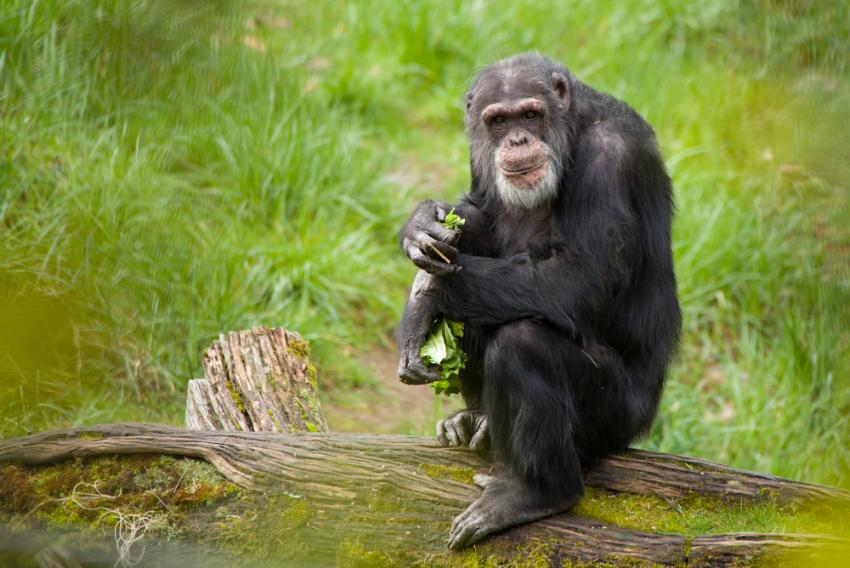

In [5]:
images = [Image.open(IMAGE_FOLDER / filename) for filename in tqdm(IMAGE_FILENAMES)]
if not IS_CI:
    display(images[0])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


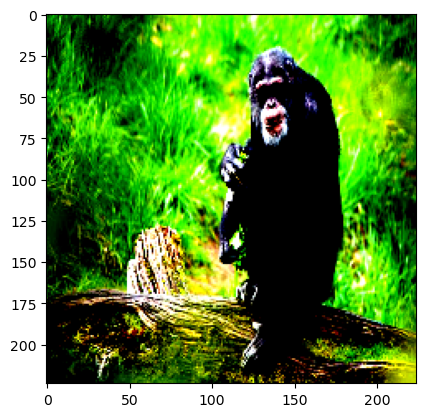

In [6]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    
])

processed_img = preprocess(images[0])
plt.imshow(rearrange(processed_img, 'c h w -> h w c'))

def prepare_data(images : list[Image.Image]) -> t.Tensor:
    
    """
    Preprocess each image and stack them into a single tensor.
    
    Return: shape (batch = len(images), num_channels = 3, height = 224, width = 224)
    """
    
    preprocessed_images = t.stack([preprocess(img) for img in images], dim = 0)
    return preprocessed_images

In [7]:
with open("/kaggle/input/w1d2-images/w1d2_imagenet_labels.json") as f:
    imagenet_labels = list(json.load(f).values())

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 80.8MB/s]


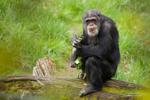

96.8233% chimpanzee, chimp, Pan troglodytes
2.7543% siamang, Hylobates syndactylus, Symphalangus syndactylus
0.1104% gorilla, Gorilla gorilla


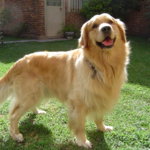

85.7538% golden retriever
1.9094% Newfoundland, Newfoundland dog
1.7417% Pekinese, Pekingese, Peke


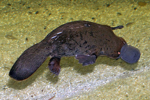

99.5011% platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
0.1933% electric ray, crampfish, numbfish, torpedo
0.0913% stingray


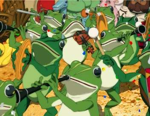

32.9490% toyshop
21.5329% pinwheel
12.6796% comic book


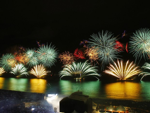

76.6134% fountain
16.2150% pineapple, ananas
1.0550% bearskin, busby, shako


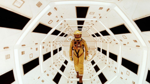

30.1640% liner, ocean liner
17.8270% paddlewheel, paddle wheel
5.5230% dome


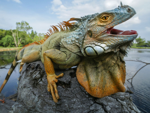

99.8201% common iguana, iguana, Iguana iguana
0.0513% agama
0.0483% frilled lizard, Chlamydosaurus kingi


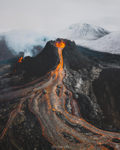

99.9989% volcano
0.0002% frying pan, frypan, skillet
0.0002% mountain tent


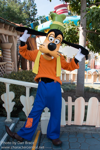

19.6240% binoculars, field glasses, opera glasses
6.9257% picket fence, paling
5.0563% plunger, plumber's helper


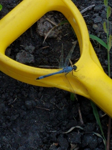

12.6659% banana
10.1128% coil, spiral, volute, whorl, helix
9.2387% bucket, pail
[367, 207, 103, 865, 562, 628, 39, 980, 447, 954]


In [8]:
def predict(model, images : list[Image.Image], print_topk_preds = 3) -> list[int]:
    
    """
    Pass the images through the model and print out the top predictions.
    For each image, `display()` the image and the most likely categories according to the model.
    
    Return : for each image, the index of the top prediction.
    """
    
    preprocessed_images = prepare_data(images)
    model.eval()
    with t.inference_mode():
        predictions = model(preprocessed_images)
    probs = predictions.softmax(dim = -1)
    _, indices = predictions.topk(print_topk_preds, dim = -1)
    
    for i, image in enumerate(images):
        img = image.copy()
        img.thumbnail((150, 150))
        display(img)
        print("\n".join(f"{100*probs[i][j]:.4f}% {imagenet_labels[j]}" for j in indices[i]))
        
    return [ind[0].item() for ind in indices]

model = models.resnet34(weights = 'DEFAULT')
pretrained_categories = predict(model, images)
print(pretrained_categories)

In [9]:
def einsum_trace(a : t.Tensor) -> t.Tensor:
    """
    Compute the trace of the square 2D input using einsum.
    """
    return t.einsum('ii', a)

test_trace(einsum_trace)
test_trace_transpose(einsum_trace)
test_trace_expand(einsum_trace)
    
def as_strided_trace(a : t.Tensor) -> t.Tensor:
    """
    Compute the trace of the square 2D input using as_strided and sum.
    
    Tip: the stride argument to `as_strided` must account for the stride of the inputs `a.stride()`.
    """
    stride = a.stride()
    a_strided = a.as_strided(size = (a.shape[0],), stride = (stride[0] + stride[1],))
    return a_strided.sum()

test_trace(as_strided_trace)
test_trace_transpose(as_strided_trace)
test_trace_expand(as_strided_trace)

__main__.test_trace passed in 0.00s.
__main__.test_trace_transpose passed in 0.00s.
__main__.test_trace_expand passed in 0.00s.
__main__.test_trace passed in 0.00s.
__main__.test_trace_transpose passed in 0.00s.
__main__.test_trace_expand passed in 0.00s.


In [10]:
def einsum_matmul(a : t.Tensor, b : t.Tensor) -> t.Tensor:
    
    """Matrix multiply 2D matrices a and b (same as a @ b)."""
    return t.einsum('ij,jk->ik', a, b)

test_matmul(einsum_matmul)
test_matmul_transpose(einsum_matmul)
test_matmul_expand(einsum_matmul)
test_matmul_skip(einsum_matmul)

def as_strided_matmul(a : t.Tensor, b : t.Tensor) -> t.Tensor:
    
    """Matrix multiply 2D matrices a and b (same as a @ b), but use as_strided this time.

    Use elementwise multiplication and sum.

    Tip: the stride argument to `as_strided` must account for the stride of the inputs `a.stride()` and `b.stride()`.
    """
    A0, A1 = a.shape
    B0, B1 = b.shape
    
    assert A1 == B0
    AS = a.stride()
    BS = b.stride()
    
    a_strided = a.as_strided(size = (A0, A1, B1), stride = (AS[0], AS[1], 0))
    b_strided = b.as_strided(size = (A0, A1, B1), stride = (0, BS[0], BS[1]))
    return (a_strided * b_strided).sum(dim = 1)

test_matmul(as_strided_matmul)
test_matmul_transpose(as_strided_matmul)
test_matmul_expand(as_strided_matmul)
test_matmul_skip(as_strided_matmul)

__main__.test_matmul passed in 0.00s.
__main__.test_matmul_transpose passed in 0.00s.
__main__.test_matmul_expand passed in 0.00s.
__main__.test_matmul_skip passed in 0.00s.
__main__.test_matmul passed in 0.00s.
__main__.test_matmul_transpose passed in 0.00s.
__main__.test_matmul_expand passed in 0.00s.
__main__.test_matmul_skip passed in 0.00s.


In [11]:
input = t.tensor([[[1, 2, 3, 4]]])
fix_me = t.tensor([[[1, 3]]])
actual = torch_conv1d(input, fix_me)
expected = t.tensor([7.0, 11.0, 15.0])
test_is_equal(actual, expected, "w1d2_test.conv1d_a")

fix_me = t.arange(12).reshape(2, 2, 3)
weights = t.tensor([[[1], [-1]]])
actual = torch_conv1d(fix_me, weights)
expected = t.tensor([[[-3, -3, -3]], [[-3, -3, -3]]])
test_is_equal(actual, expected, "w1d2_test.conv1d_b")

fix_me = t.arange(6).reshape(6, 1, 1)
weights = t.tensor([[[-1]], [[1]]])
actual = torch_conv1d(fix_me, weights)
expected = t.tensor([[[0], [0]], [[-1], [1]], [[-2], [2]], [[-3], [3]], [[-4], [4]], [[-5], [5]]])
test_is_equal(actual, expected, "w1d2_test.conv1d_c")

w1d2_test.conv1d_a passed in 0.00s.
w1d2_test.conv1d_b passed in 0.00s.
w1d2_test.conv1d_c passed in 0.00s.


In [12]:
def conv1d_minimal(x : t.Tensor, weights : t.Tensor) -> t.Tensor:
    """Like torch's conv1d using bias=False and all other keyword arguments left at their default values.
    
    x: shape(batch, in_channels, width)
    weights: shape(out_channels, in_channels, kernel_width)
    
    Returns : shape(batch, out_channels, output_width)
    """
    batch_size, in_channels1, width = x.shape
    out_channels, in_channels2, kernel_width = weights.shape
    
    assert in_channels1 == in_channels2
    x_stride = x.stride()
    new_width = width - kernel_width + 1
    new_shape = (batch_size, in_channels1, new_width, kernel_width)
    new_stride = (x_stride[0], x_stride[1], x_stride[2], x_stride[2])
    x_reshaped = x.as_strided(size = new_shape, stride = new_stride)
    return t.einsum('bcnw, ocw-> bon', x_reshaped, weights)

test_conv1d_minimal(conv1d_minimal)

__main__.test_conv1d_minimal passed in 0.03s.


In [13]:
def conv2d_minimal(x : t.Tensor, weights : t.Tensor) -> t.Tensor:
    
    """Like torch's conv2d using bias=False and all other keyword arguments left at their default values.
    
    x: shape (batch, in_channels, height, width)
    weights : shape (out_channels, in_channels, kernel_height, kernel_width)
    
    Returns : shape (batch, out_channels, output_height, output_width)
    """
    batch_size, in_channels1, height, width = x.shape
    out_channels, in_channels2, kernel_height, kernel_width = weights.shape
    
    assert in_channels1 == in_channels2
    output_height = height - kernel_height + 1
    output_width = width - kernel_width + 1
    
    original_stride = x.stride()
    new_shape = (batch_size, in_channels1, output_height, output_width, kernel_height, kernel_width)
    new_stride = (original_stride[0], original_stride[1], original_stride[2], original_stride[3], original_stride[2], original_stride[3])
    x_reshaped = x.as_strided(size = new_shape, stride = new_stride)
    return t.einsum('bchwjk, ocjk -> bohw', x_reshaped, weights)

test_conv2d_minimal(conv2d_minimal, t.float64, 1e-10)
test_conv2d_minimal(conv2d_minimal, t.float32, 0.001)

__main__.test_conv2d_minimal passed in 3.13s.
__main__.test_conv2d_minimal passed in 1.15s.


In [14]:
def pad1d(x : t.Tensor, left : int, right : int, pad_value : float) -> t.Tensor:
    
    """Return a new tensor with padding applied to the edges.
    
    x: shape (batch, in_channels, width), dtype float32
    Return : shape (batch, in_channels, left + right + width)
    """
    batch, in_channels, width = x.shape
    #padded_tensor = t.zeros((batch, in_channels, left + right + width), dtype = t.float32)
    #padded_tensor = padded_tensor.new_full(padded_tensor.shape, pad_value)
    padded_tensor = x.new_full((batch, in_channels, left + right + width), pad_value)
    padded_tensor[:, :, left : left + width] = x
    return padded_tensor

test_pad1d(pad1d)
test_pad1d_multi_channel(pad1d)

def pad2d(x : t.Tensor, left : int, right : int, top : int, bottom : int, pad_value : float) -> t.Tensor:
    
    """Return a new tensor with padding applied to the edges.
    
    x: shape (batch, in_channels, height, width), dtype float32
    
    Return : shape (batch, in_channels, top + height + bottom, left + width + right)
    """
    batch, in_channels, height, width = x.shape
    padded_tensor = x.new_full((batch, in_channels, top + height + bottom, left + width + right), pad_value)
    padded_tensor[:, :, top : top + height, left : left + width] = x
    return padded_tensor

test_pad2d(pad2d)
test_pad2d_multi_channel(pad2d)

__main__.test_pad1d passed in 0.00s.
__main__.test_pad1d_multi_channel passed in 0.00s.
__main__.test_pad2d passed in 0.00s.
__main__.test_pad2d_multi_channel passed in 0.00s.


In [15]:
def conv1d(x, weights, stride : int = 1, padding : int = 0) -> t.Tensor:
    
    """Like torch's conv1d using bias=False.
    
    x : shape (batch, in_channels, width)
    weights : shape (out_channels, in_channels, kernel_width)
    
    Returns : shape (batch, out_channels, output_width)
    """
    
    batch_size, in_channels1, width = x.shape
    out_channels, in_channels2, kernel_width = weights.shape
    
    assert in_channels1 == in_channels2
    padded_x = pad1d(x, padding, padding, 0.0)
    original_stride = padded_x.stride()
    assert stride > 0
    new_width = ((width - kernel_width + 2 * padding) // stride) + 1
    new_shape = (batch_size, in_channels1, new_width, kernel_width)
    new_stride = (original_stride[0], original_stride[1], stride * original_stride[2], original_stride[2])
    x_reshaped = padded_x.as_strided(size = new_shape, stride = new_stride)
    return t.einsum('bcnw, ocw-> bon', x_reshaped, weights)
    
    

test_conv1d(conv1d)

__main__.test_conv1d passed in 0.08s.


In [16]:
IntOrPair = Union[int, tuple[int, int]]
Pair = tuple[int, int]

def force_pair(v : IntOrPair) -> Pair:
    """Convert v to a pair of int, if it isn't already."""
    if isinstance(v, tuple):
        if len(v) != 2:
            raise ValueError(v)
        return (int(v[0]), int(v[1]))
    elif isinstance(v, int):
        return (v, v)
    raise ValueError(v)

In [17]:
def conv2d(x, weights, stride : IntOrPair = 1, padding : IntOrPair = 0) -> t.Tensor:
    
    """Like torch's conv2d using bias=False
    
    x: shape (batch, in_channels, height, width)
    weights : shape (out_channels, in_channels, kernel_height, kernel_width)
    
    Returns : shape (batch, out_channels, output_height, output_width)
    """
    
    batch_size, in_channels1, height, width = x.shape
    out_channels, in_channels2, kernel_height, kernel_width = weights.shape
    
    assert in_channels1 == in_channels2
    stride = force_pair(stride)
    padding = force_pair(padding)
    
    padded_x = pad2d(x, padding[1], padding[1], padding[0], padding[0], 0.0)
    original_stride = padded_x.stride()
    
    output_height = ((height - kernel_height + 2 * padding[0]) // stride[0]) + 1
    output_width = ((width - kernel_width + 2 * padding[1]) // stride[1]) + 1
    
    new_shape = (batch_size, in_channels1, output_height, output_width, kernel_height, kernel_width)
    new_stride = (original_stride[0], original_stride[1], stride[0] * original_stride[2], stride[1] * original_stride[3], original_stride[2], original_stride[3])
    x_reshaped = padded_x.as_strided(size = new_shape, stride = new_stride)
    return t.einsum('bchwjk, ocjk -> bohw', x_reshaped, weights)

test_conv2d(conv2d, t.float64, 1e-10)
test_conv2d(conv2d, t.float32, 0.001)

__main__.test_conv2d passed in 0.12s.
__main__.test_conv2d passed in 0.20s.


In [18]:
def maxpool2d(x : t.Tensor, kernel_size : IntOrPair, stride: Optional[IntOrPair] = None,
             padding : IntOrPair = 0) -> t.Tensor:
    
    """Like PyTorch's maxpool2d.
    
    x: shape (batch, channels, height, width)
    stride: if None, should be equal to the kernel size
    
    Return : (batch, channels, out_height, out_width)
    """
    batch_size, channels, height, width = x.shape
    
    kh, kw = force_pair(kernel_size)
    if stride == None:
        sh, sw = kh, kw
    else:
        sh, sw = force_pair(stride)
    ph, pw = force_pair(padding)
    
    padded_x = pad2d(x, pw, pw, ph, ph, -float('inf'))
    original_stride = padded_x.stride()
    oh = ((height - kh + 2 * ph) // sh) + 1
    ow = ((width - kw + 2 * pw) // sw) + 1
    
    new_shape = (batch_size, channels, oh, ow, kh, kw)
    new_stride = (original_stride[0], original_stride[1], sh * original_stride[2], sw * original_stride[3], original_stride[2], original_stride[3])
    x_reshaped = padded_x.as_strided(size = new_shape, stride = new_stride)
    return t.amax(x_reshaped, (4, 5))

test_maxpool2d(maxpool2d)

__main__.test_maxpool2d passed in 0.03s.


In [19]:
def extra_repr(module, arg_names : list[str], kwarg_names : list[str]) -> str:
    reprs = [repr(getattr(module, arg_name)) for arg_name in arg_names] + [
            f"{k}={getattr(module, k)}" for k in kwarg_names
        ]
    return ", ".join(reprs)

class MaxPool2d(nn.Module):
    
    def __init__(self, kernel_size: IntOrPair, stride: Optional[IntOrPair] = None, padding: IntOrPair = 1):
        
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = kernel_size if stride is None else stride
        self.padding = padding
        
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        """Call the functional version of maxpool2d."""
        return maxpool2d(
            x,
            self.kernel_size,
            stride = self.stride,
            padding = self.padding,
        )
    
    def extra_repr(self) -> str:
        """Add additional information to the string representation of this class."""
        return extra_repr(self, [], ["kernel_size", "stride", "padding"])
    

test_maxpool2d_module(MaxPool2d)
m = MaxPool2d(3, stride = 2, padding = 1)
print(f"Manually verify that this is an informative repr: {m}")

__main__.test_maxpool2d_module passed in 0.00s.
Manually verify that this is an informative repr: MaxPool2d(kernel_size=3, stride=2, padding=1)


In [20]:
class Linear(nn.Module):
    
    def __init__(self, in_features : int, out_features : int, bias = True):
        
        """A simple linear (technically, affine) transformation.
        
        The fields should be named `weight` and `bias` for compatibility with PyTorch.
        If `bias` is False, set `set.bias` to None.
        """
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.lb = in_features ** -0.5
        self.weight = nn.parameter.Parameter(t.empty(self.out_features, self.in_features).uniform_(-self.lb, self.lb))
        self.bias = nn.parameter.Parameter(t.empty(out_features).uniform_(-self.lb, self.lb)) if bias else None
        
    
    def forward(self, x : t.Tensor) -> t.Tensor:
        
        """
        x: shape (*, in_features)
        Return: shape (*, out_features)
        """
        x = t.einsum('...i,oi->...o', x, self.weight)
        if self.bias is not None:
            return x + self.bias
        return x
    
    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"
    
test_linear_forward(Linear)
test_linear_parameters(Linear)
test_linear_no_bias(Linear)

__main__.test_linear_forward passed in 0.01s.
__main__.test_linear_parameters passed in 0.00s.
__main__.test_linear_no_bias passed in 0.00s.


In [21]:
class Conv2d(t.nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: IntOrPair, stride: IntOrPair = 1, padding: IntOrPair = 0
    ):
        """Same as torch.nn.Conv2d with bias=False.

        Name your weight field `self.weight` for compatibility with the PyTorch version.
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = force_pair(kernel_size)
        self.stride = force_pair(stride)
        self.padding = force_pair(padding)
        in_features = in_channels * self.kernel_size[0] * self.kernel_size[1]
        bound = in_features**-0.5
        
        self.weight = nn.parameter.Parameter(t.empty((self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])).uniform_(-bound, bound))
        

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Apply the functional conv2d you wrote earlier."""
        return conv2d(x, self.weight, stride=self.stride, padding=self.padding)

    def extra_repr(self) -> str:
        """"""
        return extra_repr(self, ["in_channels", "out_channels"], ["kernel_size", "stride"])
        
    
test_conv2d_module(Conv2d)

__main__.test_conv2d_module passed in 0.00s.


In [22]:
class BatchNorm2d(nn.Module):
    
    running_mean: t.Tensor
    "running_mean: shape (num_features,)"
    running_var: t.Tensor
    "running_var: shape (num_features,)"
    num_batches_tracked: t.Tensor
    "num_batches_tracked: shape ()"
    
    def __init__(self, num_features: int, eps = 1e-05, momentum=0.1):
        """Like nn.BatchNorm2d with track_running_stats=True and affine=True.
        Name the learnable affine parameters `weight` and `bias` in that order.
        """
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.weight = nn.parameter.Parameter(t.ones(num_features))
        self.bias = nn.parameter.Parameter(t.zeros(num_features))
        self.register_buffer('running_mean', t.zeros(num_features))
        self.register_buffer('running_var', t.ones(num_features))
        self.register_buffer('num_batches_tracked', t.tensor(0))
    
    def forward(self, x : t.Tensor) -> t.Tensor:
        """Normalize each channel.
        
        Compute the variance using `torch.var(x, unbiased=False)`
        
        x: shape (batch, channels, height, width)
        Return: shape (batch, channels, height, width)
        """
        
        batch_norm_dims = (0, 2, 3)
        if self.training:
            mean = x.mean(batch_norm_dims)
            var = x.var(batch_norm_dims, unbiased = False)
            m = self.momentum
            self.running_mean.mul_(1 - m).add_(m * mean)
            self.running_var.mul_(1 - m).add_(m * var)
            self.num_batches_tracked.data += 1
        else:
            mean = self.running_mean
            var = self.running_var
            
        
        x_hat = ((x - mean.reshape(1, -1, 1, 1)) / (t.sqrt(self.eps + var.reshape(1, -1, 1, 1))))
        return self.weight.reshape(1, -1, 1, 1) * x_hat + self.bias.reshape(1, -1, 1, 1)
    
    def extra_repr(self) -> str:
        return extra_repr(self, ["num_features"], ["eps", "momentum"])
    
test_batchnorm2d_module(BatchNorm2d)
test_batchnorm2d_forward(BatchNorm2d)
test_batchnorm2d_running_mean(BatchNorm2d)

__main__.test_batchnorm2d_module passed in 0.00s.
__main__.test_batchnorm2d_forward passed in 0.01s.
__main__.test_batchnorm2d_running_mean passed in 0.00s.


In [23]:
class ReLU(nn.Module):
    def forward(self, x : t.Tensor) -> t.Tensor:
        return t.maximum(t.tensor(0.), x)

In [24]:
class Sequential(nn.Module):
    def __init__(self, *modules: nn.Module):
        """
        Call `self.add_module` on each provided module, giving each one a unique (within this Sequential) name.
        Internally, this adds them to the dictionary `self._modules` in the base class, which means they'll be included in self.parameters() as desired.
        """
        super().__init__()
        for i, module in enumerate(modules):
            self.add_module(str(i), module)

    def forward(self, x: t.Tensor) -> t.Tensor:
        """Chain each module together, with the output from one feeding into the next one."""
        
        for module in self._modules.values():
            x = module(x)
            
        return x
    
test_sequential(Sequential)
test_sequential_forward(Sequential)

__main__.test_sequential passed in 0.00s.
__main__.test_sequential_forward passed in 0.00s.


In [25]:
class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input: t.Tensor) -> t.Tensor:
        """Flatten out dimensions from start_dim to end_dim, inclusive of both.

        Return a view if possible, otherwise a copy.
        """
        
        self.end_dim = self.end_dim + input.ndim if self.end_dim < 0 else self.end_dim
        out_dim = (
            [input.shape[i] for i in range(0, self.start_dim)]
            + [-1]
            + [input.shape[i] for i in range(self.end_dim + 1, input.ndim)]
        )
        return input.reshape(out_dim)
        
        

    def extra_repr(self) -> str:
        return extra_repr(self, [], ['start_dim', 'end_dim'])
    
test_flatten(Flatten)
test_flatten_is_view(Flatten)

__main__.test_flatten passed in 0.00s.
__main__.test_flatten_is_view passed in 0.00s.


In [26]:
class AveragePool(nn.Module):
    
    def forward(self, x : t.Tensor) -> t.Tensor:
        
        """
        
        x: shape (batch, channels, height, width)
        Return: shape (batch, channels)
        """
        dims = (2, 3)
        return x.mean(dims)

In [27]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_feats : int, out_feats : int, first_stride = 1):
        
        """A single residual block with optional downsampling.
        
        For compatibility with the pretrained model, declare the left side branch first using a `Sequential`.
        If first_stride is > 1, this means the optional (conv + bn) should be present on the right branch.
        """
        
        super().__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.first_stride = first_stride
        
        self.relu = ReLU()
        
        self.left_branch = Sequential(
            Conv2d(self.in_feats, self.out_feats, 3, first_stride, 1),
            BatchNorm2d(self.out_feats),
            ReLU(),
            Conv2d(self.out_feats, self.out_feats, 3, padding = 1),
            BatchNorm2d(self.out_feats),
        )
        
        if self.first_stride > 1:
            self.right_branch = Sequential(
                Conv2d(self.in_feats, self.out_feats, 1, first_stride),
                BatchNorm2d(self.out_feats),
            )
        else:
            self.right_branch = None
            
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        """Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / stride, width / stride)

        If no downsampling block is present, the addition should just add the left branch's output to the input.
        """
        
        first_branch_output = self.left_branch(x)
        residual = x if self.right_branch is None else self.right_branch(x)
        return self.relu(residual + first_branch_output)
            
    

In [28]:
class BlockGroup(nn.Module):
    
    def __init__(self, n_blocks: int, in_feats: int, out_feats: int, first_stride = 1):
        """An n_blocks-long sequence of ResidualBlock where only the first block uses the provided stride."""
        
        super().__init__()
        self.n_blocks = n_blocks
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.first_stride = first_stride
        
        self.blocks = Sequential(
            ResidualBlock(self.in_feats, self.out_feats, first_stride),
            *(ResidualBlock(self.out_feats, self.out_feats) for _ in range(self.n_blocks - 1)),
        )
        
        
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        """Compute the forward pass.
        x: shape (batch, in_feats, height, width)
        
        Return: shape (batch, out_feats, height / first_stride, width / first_stride)
        """
        return self.blocks(x)
        

In [29]:
class ResNet34(nn.Module):
    
    def __init__(
        self,
        n_blocks_per_group = [3, 4, 6, 3],
        out_features_per_group = [64, 128, 256, 512],
        strides_per_group = [1, 2, 2, 2],
        n_classes = 1000,
    ):
        super().__init__()
        out_channels = 64
        
        self.in_layer = Sequential(
            Conv2d(3, out_channels, 7, 2, 3),
            BatchNorm2d(out_channels),
            ReLU(),
            MaxPool2d(3, 2, 1),
        )
        
        out_features = [out_channels] + out_features_per_group[:-1]
        print(out_features)
        self.resid_layers = Sequential(
            
            *(
                BlockGroup(*args)
                for args in zip(
                    n_blocks_per_group,
                    out_features,
                    out_features_per_group,
                    strides_per_group,
                )
            )
        )
        
        self.out_layers = Sequential(
            AveragePool(),
            Flatten(),
            Linear(512, n_classes),
        )
        
        
    
    def forward(self, x : t.Tensor) -> t.Tensor:
        
        """
        x: shape (batch, channels, height, width)
        
        Return: shape (batch, n_classes)
        """
        x = self.in_layer(x)
        x = self.resid_layers(x)
        x = self.out_layers(x)
        return x

In [30]:
pretrained_model = models.resnet34(pretrained = True)
custom_resnet34 = ResNet34()
pretrained_state_dict = pretrained_model.state_dict().items()
custom_state_dict = custom_resnet34.state_dict().items()
assert len(pretrained_state_dict) == len(custom_state_dict)

param_shape = pd.DataFrame.from_records(
    [(pk, tuple(pv.shape), ck, tuple(cv.shape)) for ((pk, pv), (ck, cv)) in zip(pretrained_state_dict, custom_state_dict)],
    columns = ['pretrained key', 'pretrained shape', 'custom key', 'custom shape'],
)





/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[64, 64, 128, 256]


In [31]:
with pd.option_context("display.max_rows", None):  # type: ignor
    display(param_shape)

,pretrained key,pretrained shape,custom key,custom shape
0,conv1.weight,"(64, 3, 7, 7)",in_layer.0.weight,"(64, 3, 7, 7)"
1,bn1.weight,"(64,)",in_layer.1.weight,"(64,)"
2,bn1.bias,"(64,)",in_layer.1.bias,"(64,)"
3,bn1.running_mean,"(64,)",in_layer.1.running_mean,"(64,)"
4,bn1.running_var,"(64,)",in_layer.1.running_var,"(64,)"
5,bn1.num_batches_tracked,(),in_layer.1.num_batches_tracked,()
6,layer1.0.conv1.weight,"(64, 64, 3, 3)",resid_layers.0.blocks.0.left_branch.0.weight,"(64, 64, 3, 3)"
7,layer1.0.bn1.weight,"(64,)",resid_layers.0.blocks.0.left_branch.1.weight,"(64,)"
8,layer1.0.bn1.bias,"(64,)",resid_layers.0.blocks.0.left_branch.1.bias,"(64,)"
9,layer1.0.bn1.running_mean,"(64,)",resid_layers.0.blocks.0.left_branch.1.running_...,"(64,)"


In [32]:
assert all(x[1].shape == y[1].shape for x, y in zip(pretrained_state_dict, custom_state_dict))
d = OrderedDict((my_key[0], pretrained_value[1]) for my_key, pretrained_value in zip(custom_state_dict, pretrained_state_dict))
custom_resnet34.load_state_dict(d, strict= True)

<All keys matched successfully>

In [33]:
def check_nan_hook(module: nn.Module, inputs, output):
    """Example of a hook function that can be registered to a module."""
    x = inputs[0]
    if t.isnan(x).any():
        raise ValueError(module, x)
    out = output[0]
    if t.isnan(out).any():
        raise ValueError(module, x)


def add_hook(module: nn.Module) -> None:
    """Remove any existing hooks and register our hook.

    Use model.apply(add_hook) to recursively apply the hook to model and all submodules.
    """
    remove_hooks(module)
    module.register_forward_hook(check_nan_hook)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


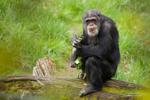

96.8233% chimpanzee, chimp, Pan troglodytes
2.7543% siamang, Hylobates syndactylus, Symphalangus syndactylus
0.1104% gorilla, Gorilla gorilla


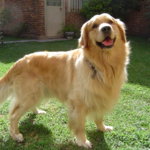

85.7539% golden retriever
1.9094% Newfoundland, Newfoundland dog
1.7417% Pekinese, Pekingese, Peke


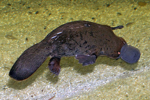

99.5011% platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus
0.1933% electric ray, crampfish, numbfish, torpedo
0.0913% stingray


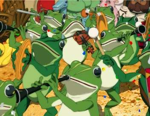

32.9489% toyshop
21.5330% pinwheel
12.6796% comic book


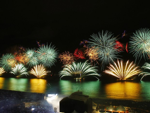

76.6134% fountain
16.2150% pineapple, ananas
1.0550% bearskin, busby, shako


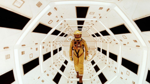

30.1639% liner, ocean liner
17.8270% paddlewheel, paddle wheel
5.5230% dome


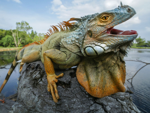

99.8201% common iguana, iguana, Iguana iguana
0.0513% agama
0.0483% frilled lizard, Chlamydosaurus kingi


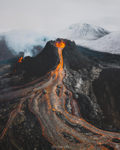

99.9989% volcano
0.0002% frying pan, frypan, skillet
0.0002% mountain tent


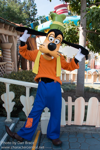

19.6239% binoculars, field glasses, opera glasses
6.9257% picket fence, paling
5.0563% plunger, plumber's helper


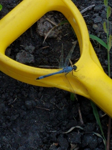

12.6659% banana
10.1128% coil, spiral, volute, whorl, helix
9.2387% bucket, pail


AssertionError: 

In [34]:
custom_resnet34.apply(add_hook)
pred = predict(custom_resnet34, images)
test_same_predictions(pred)

In [35]:
cifar_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}


def get_cifar10():
    """Download (if necessary) and return the CIFAR10 dataset."""
    "The following is a workaround for this bug: https://github.com/pytorch/vision/issues/5039"
    if sys.platform == "win32":
        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context
    "Magic constants taken from: https://docs.ffcv.io/ffcv_examples/cifar10.html"
    mean = t.tensor([125.307, 122.961, 113.8575]) / 255
    std = t.tensor([51.5865, 50.847, 51.255]) / 255
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
    cifar_train = torchvision.datasets.CIFAR10("w1d2_cifar10_train", transform=transform, download=True, train=True)
    cifar_test = torchvision.datasets.CIFAR10("w1d2_cifar10_train", transform=transform, download=True, train=False)
    return (cifar_train, cifar_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 44306294.59it/s]


Extracting w1d2_cifar10_train/cifar-10-python.tar.gz to w1d2_cifar10_train
Files already downloaded and verified
Mean value of each channel:  tensor([-0.0553, -0.0727, -0.0905])
Mean value of each channel:  tensor([-0.0553, -0.0727, -0.0905])


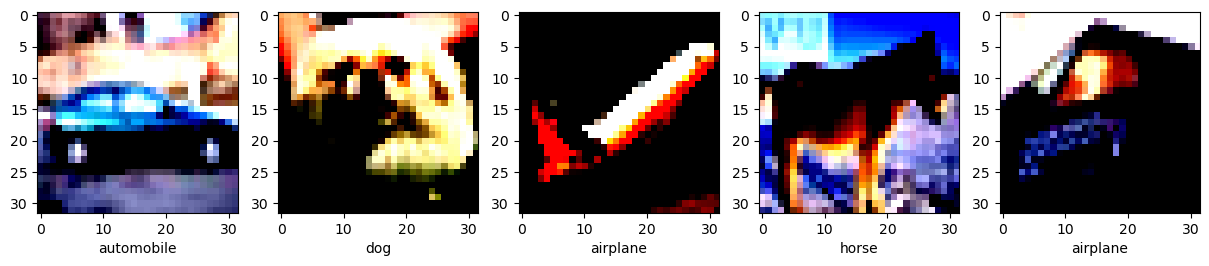

In [36]:
(cifar_train, cifar_test) = get_cifar10()
trainloader = DataLoader(cifar_train, batch_size = 512, shuffle = True, pin_memory = True)
testloader = DataLoader(cifar_test, batch_size = 512, pin_memory = True)

batch = next(iter(trainloader))
print("Mean value of each channel: ", batch[0].mean((0, 2, 3)))
print("Mean value of each channel: ", batch[0].mean((0, 2, 3)))
(fig, axes) = plt.subplots(ncols=5, figsize=(15, 5))
for (i, ax) in enumerate(axes):
    ax.imshow(rearrange(batch[0][i], "c h w -> h w c"))
    ax.set(xlabel=cifar_classes[batch[1][i].item()])

In [37]:


MODEL_FILENAME = "./w1d2_resnet34_cifar10.pt"
device = "cuda" if t.cuda.is_available() else "cpu"

def train(trainloader : DataLoader, epochs : int) -> ResNet34:
    
    model = ResNet34(n_classes = 10).to(device).train()
    optimizer = t.optim.Adam(model.parameters())
    loss_fn = t.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for (i, (x, y)) in enumerate(tqdm(trainloader)):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch}, train loss is {loss}")
        print(f"Saving model to: {os.path.abspath(MODEL_FILENAME)}")
        t.save(model, MODEL_FILENAME)
        
    return model

print("Training model from scratch")
model = train(trainloader, epochs = 8)

Training model from scratch
[64, 64, 128, 256]


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0, train loss is 1.1782472133636475
Saving model to: /kaggle/working/w1d2_resnet34_cifar10.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1, train loss is 1.0400629043579102
Saving model to: /kaggle/working/w1d2_resnet34_cifar10.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2, train loss is 0.8703902959823608
Saving model to: /kaggle/working/w1d2_resnet34_cifar10.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3, train loss is 0.7289813160896301
Saving model to: /kaggle/working/w1d2_resnet34_cifar10.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4, train loss is 0.5508593916893005
Saving model to: /kaggle/working/w1d2_resnet34_cifar10.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5, train loss is 0.47679346799850464
Saving model to: /kaggle/working/w1d2_resnet34_cifar10.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6, train loss is 0.47638335824012756
Saving model to: /kaggle/working/w1d2_resnet34_cifar10.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7, train loss is 0.39036279916763306
Saving model to: /kaggle/working/w1d2_resnet34_cifar10.pt


In [38]:
model.eval()
model.apply(add_hook)
loss_fn = t.nn.CrossEntropyLoss(reduction = 'sum')
with t.inference_mode():
    n_correct = 0
    n_total = 0
    loss_total = 0.0
    for (i, (x, y)) in enumerate(tqdm(testloader)):
        x = x.to(device)
        y = y.to(device)
        with t.autocast(device):
            y_hat = model(x)
            loss_total += loss_fn(y_hat, y).item()
        n_correct += (y_hat.argmax(dim=-1) == y).sum().item()
        n_total += len(x)
        
    print(f"Test accuracy: {n_correct} / {n_total} = {100 * n_correct / n_total:.2f}%")
    print(f"Test loss: {loss_total / n_total}")

  0%|          | 0/20 [00:00<?, ?it/s]

Test accuracy: 6820 / 10000 = 68.20%
Test loss: 1.1029140380859375
